# Figure 3. Results from production multiobjective

In [1]:
# imports
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import colormaps as cmaps
import seaborn as sns 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler #

## B. 3D plot with growth/cost/production.

* Plots the growth rate on the x-axis against medium cost on the y-axis against production rate on the z-axis for each candidate medium.
* Each dot is colour-coded according to the iteration it resulted from.
* the performance of the baseline medium is plotted onto the graph to allow for visual performance comparison
* Saves the figure as Figure3B.png

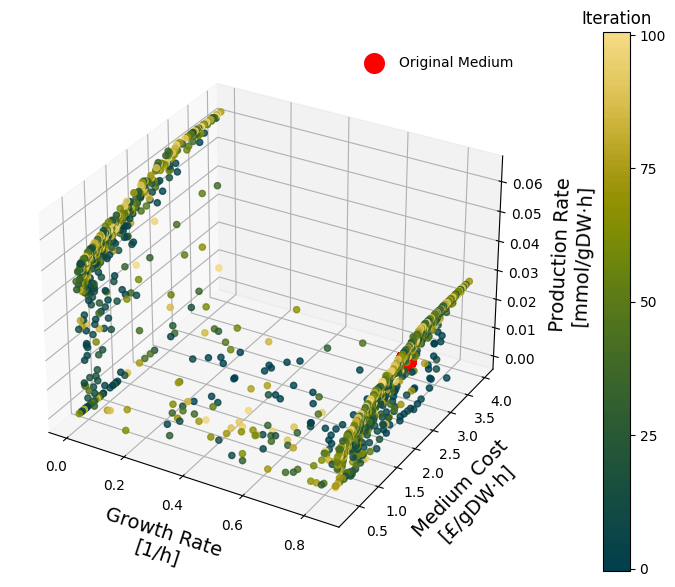

In [2]:
data = pd.read_csv("../data/Figure3B.csv")
# data = pd.read_csv("Figure3B.csv")
figname = "../figs/Figure3B.png"
# figname = "Figure3B.png"

# Create the plot with given size
fig = plt.figure(figsize = (9, 7))
axes = fig.add_subplot(projection = '3d')

# Define colour mapping - 1 for random initial points, 1 each per batch (n_iter)
n_start = data["n_start"][0]
n_batch = data["n_batch"][0]
n_candidates = data["n_candidates"][0]

"""
print("\nn_start = ", n_start, 
      "\nn_batch = ", n_batch, 
      "\nn_candidates = ", n_candidates,
      "\nlength = ", n_start + n_batch * n_candidates,
      "\nlen(data) = ", len(data))
"""

 # Generate distinct colours
colours = cmaps.bamako.cut(0.05, "right")(np.linspace(0, 1, n_batch + 1))
# Create a custom colourmap for the colour bar
cmap = mcolors.ListedColormap(colours)

# Create an array to store colours for each data point
point_colours = np.zeros(len(data), dtype = object)

# Assign first n_start points the same colour
point_colours[:n_start] = [colours[0]] * n_start
# Assign different colours to each batch
for i in range(n_batch):
    start_idx = n_start + i * n_candidates
    end_idx = start_idx + n_candidates
    point_colours[start_idx:end_idx] = [colours[i + 1]] * (end_idx - start_idx) # Assign a new color per batch
# Set boundaries between each batch, from -0.5 to n_batch + 0.5
boundaries = np.arange(n_batch + 2) - 0.5
norm = mcolors.BoundaryNorm(boundaries, cmap.N)

# transform cost data from 10^{-3} £/gDW·h to £/gDW·h
data["cost"] = data["cost"] * 1e-3
# Scatter plot with custom colours, applying transparence (alpha = 0.8)    
axes.scatter(
    data["growth_rate"],
    data["cost"],
    data["production"],
    c = point_colours, alpha = 0.8, zorder=1)


# axes
axes.set_xlabel("Growth Rate\n[1/h]", fontsize = 14, labelpad = 12)
axes.set_ylabel("Medium Cost\n[£/gDW·h]", fontsize = 14, labelpad = 12)
axes.set_zlabel("Production Rate\n[mmol/gDW·h]", fontsize = 14, labelpad = 12)
axes.xaxis.set_tick_params(width = 2, labelsize = 10)
axes.yaxis.set_tick_params(width = 2, labelsize = 10)
axes.zaxis.set_tick_params(width = 2, labelsize = 10)
"""
axes.spines["top"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.spines["bottom"].set_linewidth(1.5)
axes.spines["left"].set_linewidth(1.5)
"""
# Add the color bar
tick_positions = np.arange(0, n_batch + 1, 5)
sm = cm.ScalarMappable(cmap = cmap, norm = norm)
cbar = fig.colorbar(sm, ax = axes, ticks = tick_positions, pad = 0.11) # pad defines distance
cbar.ax.set_title("Iteration", fontsize = 12)
cbar.ax.set_yticks([0, 25, 50, 75, 100])
cbar.ax.tick_params(which = "minor", size = 0) # turn off minor ticks at colour boundaries

# Plot original medium for comparison
axes.scatter(
    data["init_growth_rate"][0],
    data["init_cost"][0] * 1e-3,
    data["init_production"],
    color = "red", marker = "o", 
    label = "Original Medium", s = 200, zorder = 5000
    )

# Display the legend
axes.legend()
axes.legend(edgecolor = "none", frameon = False, fontsize=10)
# axes.view_init(azim=90, elev = 5)

# Show the plot
plt.show()

# fig.set_size_inches(9, 7)  # Consistent physical size in inches
fig.savefig(figname, dpi = 300, bbox_inches = None)

## C. PCA with colors of different types of samples.
* Performs PCA on all medium compositions using only the components as variables.
* Plots the result colour-coding the data points by performance class (relative to orig. medium).
* Lists the count of each category in legend.
* The final plot is saved as png file.

In [5]:
data = pd.read_csv("../data/Figure3CD.csv")

'''Perform and plot PCA using only the medium components (columns starting with "EX_")'''
# Select only the columns starting with "EX_"
medium_components = data.filter(like = "EX_", axis = 1)

# Standardize the medium components
scaler = StandardScaler()
medium_components_scaled = scaler.fit_transform(medium_components)

# Perform PCA
pca = PCA(n_components = 2)
pca_result = pca.fit_transform(medium_components_scaled)

# Add PCA results to the dataframe for plotting
data["PCA1"] = pca_result[:, 0]
data["PCA2"] = pca_result[:, 1]

fig, axes = plt.subplots(4, 1, figsize=(3,8), sharex=True, sharey=True)
cmap = cmaps.bamako
cmap_2 = cmaps.bamako(np.linspace(0, 1, 2))
for hue, i in zip(['is pareto', 'production rate', 'growth rate', 'cost'], range(4)):
    ax = axes[i]
    
    if hue != 'is pareto':
        sns.scatterplot(
        x = "PCA1", y = "PCA2", hue=hue,
        data = data, s = 50, edgecolor = None, alpha = 0.7, ax = ax, legend=False, palette=cmap)
        ax.set_title(hue)

    else: 
        pareto = data.loc[data['is pareto'] == True].sample(25)
        nonpareto = data.loc[data['is pareto'] == False]

        #sns.kdeplot(x = "PCA1", y = "PCA2", data = data, s = 100, edgecolor = "k", alpha = 0.7, fill=True, ax=ax)
        sns.kdeplot(x = "PCA1", y = "PCA2", data = data, edgecolor = "k", alpha = 0.7, fill=True, ax=ax)
        sns.scatterplot(x='PCA1', y='PCA2', data=pareto, color='k', marker='x', 
                        label='Pareto optimal samples', ax=ax)
        ax.legend()
        ax.legend(edgecolor = "none", frameon = False, fontsize=10)

    
    ax.xaxis.set_tick_params(width = 2, labelsize = 10)
    ax.yaxis.set_tick_params(width = 2, labelsize = 10)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_linewidth(1.5)
    ax.set_ylabel('PC 2', fontsize=12)
    ax.set_xlabel('PC 1', fontsize=12)


fig.tight_layout()
fig.savefig('../figs/Figure3C.png', dpi = 300, bbox_inches = None)
# fig.savefig('Figure3C.png', dpi = 300, bbox_inches = None)

FileNotFoundError: [Errno 2] No such file or directory: '../data/Figure3CD.csv'

## D. Box plot of pareto-optimal medium component distributions

C:\Users\hanicola\AppData\Local\Temp\ipykernel_42628\3531997514.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pareto, y='exchange', x='flux', palette=cmap)
C:\Users\hanicola\AppData\Local\Temp\ipykernel_42628\3531997514.py:20: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(data=pareto, y='exchange', x='flux', palette=cmap)
C:\Users\hanicola\AppData\Local\Temp\ipykernel_42628\3531997514.py:20: UserWarning: 
The palette list has fewer values (11) than needed (13) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=pareto, y='exchange', x='flux', palette=cmap)
C:\Users\hanicola\AppData\Local\Temp\ipykernel_42628\3531997514.py:22: UserWarning: set_ticklabels() should only be used with a fixed number o

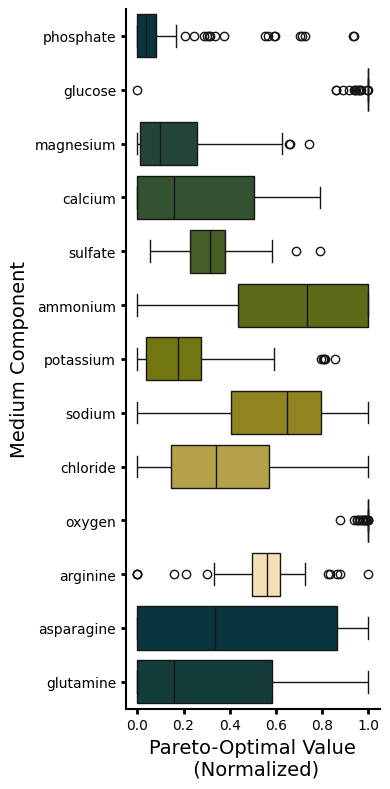

In [ ]:
data = pd.read_csv("../data/Figure3CD.csv")

pareto = data.loc[data['is pareto'] == True]
pareto = pareto.drop(columns=['is pareto', 'growth rate', 'cost', 'production rate', 'n_batch', 'n_start', 
                              'n_candidates', 'EX_cu2_e', 'EX_mobd_e', 'EX_mn2_e', 'EX_zn2_e', 'EX_fe2_e',
                              'EX_ni2_e', 'EX_cobalt2_e'])

#Normalize each exchange column to its min/max values
norm_pareto = pd.DataFrame()
for c in pareto.columns:
    min = data[c].min()
    max = data[c].max()
    norm_pareto[c] = (pareto[c] - min)/(max-min)

pareto = norm_pareto.melt(var_name='exchange', value_name='flux')

cmap = cmaps.bamako(np.linspace(0, 1, 11))
fig, axes = plt.subplots(figsize=(4, 8))
sns.boxplot(data=pareto, y='exchange', x='flux', palette=cmap)

axes.set_yticklabels([
    'phosphate', 'glucose', 'magnesium', 'calcium', 'sulfate', 
    'ammonium', 'potassium', 'sodium', 'chloride', 'oxygen', 
    'arginine', 'asparagine', 'glutamine'],
    ha='right', fontsize=12)
axes.set_ylabel('Medium Component', fontsize = 14)
axes.set_xlabel(f'Pareto-Optimal Value\n (Normalized)', fontsize = 14)
axes.xaxis.set_tick_params(width = 2, labelsize = 10)
axes.yaxis.set_tick_params(width = 2, labelsize = 10)
axes.spines["top"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.spines["bottom"].set_linewidth(1.5)
axes.spines["left"].set_linewidth(1.5)
fig.tight_layout()
fig.savefig('../figs/Figure3D.png', dpi = 300, bbox_inches = None)